本节将使用Keras来更简洁地实现基于循环神经网络的语言模型。首先，我们读取周杰伦专辑歌词数据集。

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as f
import numpy as np
import math
import sys
import time
sys.path.append("..") 
import d2lzh_tensorflow2 as d2l

(corpus_indices, char_to_idx, idx_to_char, vocab_size) = d2l.load_data_jay_lyrics()

## 6.5.1 定义模型

Keras的`Rnn`模块提供了循环神经网络的实现。下面构造一个含**单隐藏层**、**隐藏单元个数为256**的循环神经网络层`rnn_layer`，并对权重做初始化。

In [2]:
num_hiddens = 256
cell = keras.layers.SimpleRNNCell(num_hiddens,kernel_initializer='glorot_uniform')
rnn_layer = keras.layers.RNN(cell, time_major=True, return_sequences=True, return_state=True)

与上一节中实现的循环神经网络不同，这里`rnn_layer`的输入形状为(时间步数, 批量大小, 输入个数)。其中输入个数即one-hot向量长度（词典大小）。此外，`rnn_layer`作为`nn.RNN`实例，在前向计算后会分别返回输出和隐藏状态h，其中输出指的是隐藏层在**各个时间步**上计算并输出的隐藏状态，它们通常作为后续输出层的输入。需要强调的是，该“输出”本身并不涉及输出层计算，形状为(时间步数, 批量大小, 隐藏单元个数)。而`nn.RNN`实例在前向计算返回的隐藏状态指的是隐藏层在**最后时间步**的隐藏状态：当隐藏层有多层时，每一层的隐藏状态都会记录在该变量中；对于像**长短期记忆**（LSTM），隐藏状态是一个元组(h, c)，即hidden state和cell state。我们会在本章的后面介绍长短期记忆和深度循环神经网络。关于循环神经网络（以LSTM为例）的输出，可以参考下图（[图片来源](https://stackoverflow.com/questions/48302810/whats-the-difference-between-hidden-and-output-in-pytorch-lstm/48305882)）。

<div align=center>
<img width="500" src="../img/chapter06/6.5.png"/>
</div>
<div align=center>循环神经网络（以LSTM为例）的输出</div>

来看看我们的例子，输出形状为(时间步数, 批量大小, 隐藏单元个数)，隐藏状态h的形状为(层数, 批量大小, 隐藏单元个数)。

In [3]:
batch_size = 2
state = cell.get_initial_state(batch_size=batch_size, dtype=tf.float32)

num_steps = 35
X = tf.random.uniform(shape=(num_steps, batch_size, vocab_size))
Y, state_new = rnn_layer(X, state)
Y.shape, len(state_new), state_new[0].shape

(TensorShape([35, 2, 256]), 2, TensorShape([256]))

In [4]:
state_new.shape   # 隐藏层输出一直是 n * h

TensorShape([2, 256])

In [7]:
# state_new

> 如果`rnn_layer`是`nn.LSTM`实例，那么上面的输出是什么？

接下来我们继承`Module`类来定义一个完整的循环神经网络。它首先将输入数据使用one-hot向量表示后输入到`rnn_layer`中，然后使用全连接输出层得到输出。输出个数等于词典大小`vocab_size`。

In [5]:
# 本类已保存在d2lzh包中方便以后使用
class RNNModel(keras.layers.Layer):
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel,self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.dense = keras.layers.Dense(vocab_size)
        
    def call(self, inputs, state):
        # 将输入装置成（num_steps, batch_size) 后获取one-hot向量表示
        X = tf.one_hot(tf.transpose(inputs),self.vocab_size)
        Y, state = self.rnn(X, state)
        # 全连接层会首先将Y的形状变成(num_steps * batch_size, num_hiddens)，它的输出
        # 形状为(num_steps * batch_size, vocab_size)  # 一句话有多长 * 每个批量有多少句话，  onehot向量的长度。
        output = self.dense(tf.reshape(Y,(-1, Y.shape[-1])))
        return output, state
    
    def get_initial_state(self, *args, **kwargs):
        return self.rnn.cell.get_initial_state(*args, **kwargs)

## 6.5.2 训练模型

同上一节一样，下面定义一个预测函数。这里的实现区别在于**前向计算**和**初始化隐藏状态的函数接口**。

In [6]:
# 本函数已保存在d2lzh包中方便以后使用
def predict_rnn_keras(prefix, num_chars, model, vocab_size, idx_to_char,
                      char_to_idx):
    # 使用model的成员函数来初始化隐藏状态
    state = model.get_initial_state(batch_size=1,dtype=tf.float32)
    output = [char_to_idx[prefix[0]]]
    #print("output:",output)
    for t in range(num_chars + len(prefix) - 1):
        X = np.array([output[-1]]).reshape((1, 1))
        #print("X",X)
        Y, state = model(X, state)  # 前向计算不需要传入模型参数
        #print("Y",Y)
        #print("state:",state)
        if t < len(prefix) - 1:
            output.append(char_to_idx[prefix[t + 1]])
            #print(char_to_idx[prefix[t + 1]])
        else:
            output.append(int(np.array(tf.argmax(Y,axis=-1))))
            #print(int(np.array(tf.argmax(Y[0],axis=-1))))
    return ''.join([idx_to_char[i] for i in output])

让我们使用权重为随机值的模型来预测一次。

In [7]:
model = RNNModel(rnn_layer, vocab_size)
predict_rnn_keras('分开', 10, model, vocab_size,  idx_to_char, char_to_idx)

'分开准乖语放熬箱馆纯临h'

接下来实现训练函数。算法同上一节的一样，但**这里只使用了相邻采样来读取数据**。

In [8]:
# 本函数已保存在d2lzh包中方便以后使用
# 计算裁剪后的梯度
def grad_clipping(grads,theta):
    norm = np.array([0])
    for i in range(len(grads)):
        norm+=tf.math.reduce_sum(grads[i] ** 2)
    #print("norm",norm)
    norm = np.sqrt(norm).item()
    new_gradient=[]
    if norm > theta:
        for grad in grads:
            new_gradient.append(grad * theta / norm)
    else:
        for grad in grads:
            new_gradient.append(grad)  
    #print("new_gradient",new_gradient)
    return new_gradient
  
# 本函数已保存在d2lzh包中方便以后使用
def train_and_predict_rnn_keras(model, num_hiddens, vocab_size, 
                                corpus_indices, idx_to_char, char_to_idx,
                                num_epochs, num_steps, lr, clipping_theta,
                                batch_size, pred_period, pred_len, prefixes):
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer=tf.keras.optimizers.SGD(learning_rate=lr)
    
    for epoch in range(num_epochs):
        l_sum, n, start = 0.0, 0, time.time()
        data_iter = d2l.data_iter_consecutive(
            corpus_indices, batch_size, num_steps)
        state = model.get_initial_state(batch_size=batch_size,dtype=tf.float32)
        for X, Y in data_iter:
            with tf.GradientTape(persistent=True) as tape:
                (outputs, state) = model(X, state)
                y = Y.T.reshape((-1,))
                l = loss(y,outputs)
            
            grads = tape.gradient(l, model.variables)
            # 梯度裁剪
            grads=grad_clipping(grads, clipping_theta)
            optimizer.apply_gradients(zip(grads, model.variables))  # 因为已经误差取过均值，梯度不用再做平均
            l_sum += np.array(l).item() * len(y)
            n += len(y)

        if (epoch + 1) % pred_period == 0:
            print('epoch %d, perplexity %f, time %.2f sec' % (
                epoch + 1, math.exp(l_sum / n), time.time() - start))
            for prefix in prefixes:
                print(' -', predict_rnn_keras(
                    prefix, pred_len, model, vocab_size,  idx_to_char,
                    char_to_idx))

使用和上一节实验中一样的超参数（除了学习率）来训练模型。

In [9]:
num_epochs, batch_size, lr, clipping_theta = 250, 32, 1e2, 1e-2
pred_period, pred_len, prefixes = 50, 50, ['分开', '不分开']
train_and_predict_rnn_keras(model, num_hiddens, vocab_size, 
                            corpus_indices, idx_to_char, char_to_idx,
                            num_epochs, num_steps, lr, clipping_theta,
                            batch_size, pred_period, pred_len, prefixes)

epoch 50, perplexity 27.314924, time 0.85 sec
 - 分开 我不我 别子我 三你四 干给我 干什我 别什我 干你我 干什我 别什我 干什我 干什我 干什我 干
 - 不分开 我不的再爱 就不的 我 我这样你 一有了人 快使用双 棍 用发的敌 后天我双截棍 一知哈兮 快使用
epoch 100, perplexity 3.317610, time 0.68 sec
 - 分开 我想我的天是来人过 说放 在念很 爱梭她的起的天口 说么我 别怪么 我想好的力牵着每 手是我人做得
 - 不分开觉 你已经离开我 不知不觉 我跟了这节奏 后知后觉 又过了一个秋 后知后觉 我该好好生活 我该好好生
epoch 150, perplexity 1.647436, time 0.70 sec
 - 分开 我候无的太写 不风忙这里动寻找桌椅 想著的我斑昏的誓肉 不峡谷的形呼啸而沼 是谁说没默 有一条热昏
 - 不分开觉 你已经离开我 不知不觉 我跟了这节奏 后知后觉 又过了一个秋 后知后觉 我该好好生活 我该好好生
epoch 200, perplexity 1.434796, time 1.18 sec
 - 分开 一颗我的话很就 一说到我 爸颗么年 怎谁内容 你一我有 别一有容 不你心同 我有就到宠 我的天空 
 - 不分开觉 你已经离开我 不知不觉 我跟了这节奏 后知后觉 又过了一个秋 后知后觉 我该好好生活 我该好好生
epoch 250, perplexity 1.497045, time 0.96 sec
 - 分开 我候无 穿过我 多地却么 回来线掌 耍颗我枪见重人 我后悔没让你看著 这些的听 撒人的可 对是对功
 - 不分开觉 你已经离开我 不知不觉 我跟了这节奏 后知后觉 又过了一个秋 后知后觉 我该好好生活 我该好好生


**和给出的文档中的输出，差太远了。0403,增加from_logits=True
完整地点：loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)，
后面好多了！**

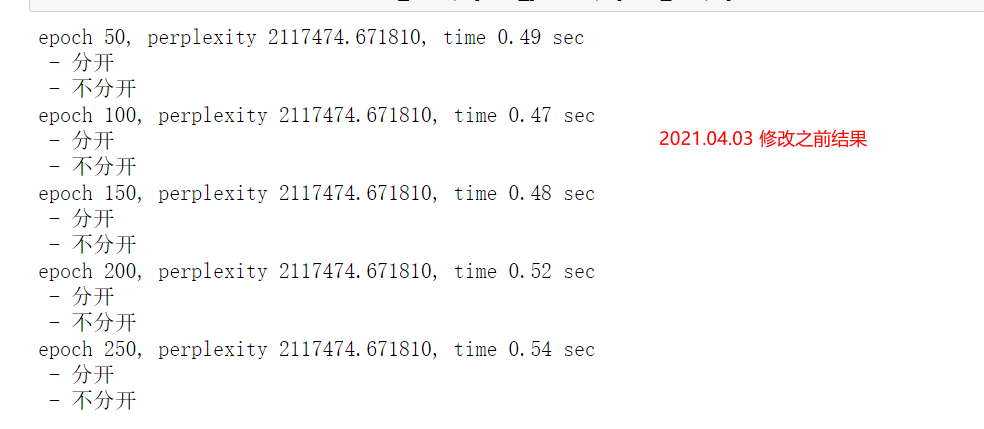

## 小结

* Keras的`layers`模块提供了循环神经网络层的实现。
* Keras的`layers.RNN`实例在前向计算后会分别返回输出和隐藏状态。该前向计算并不涉及输出层计算。

-----------

> 注：除代码外本节与原书此节基本相同，[原书传送门](https://zh.d2l.ai/chapter_recurrent-neural-networks/rnn-gluon.html)

